In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

# US House

## Final File - Load

In [5]:
pwd

'/Users/lilyfalk/sandbox/pdv-va'

In [6]:
final = gpd.read_file('./vest_va/va_2018_ushouse/va_2018_ushouse.shp')

In [7]:
print(final.shape)

(2463, 10)


# Election Results: US House

## Read in election results and append since files split accross districts

In [8]:
# 11 congressional districts in VA - need to load in election results for each separately (as provided by the state)
district = [str(1), str(2), str(3), str(4), str(5), str(6), str(7), str(8), str(9), str(10), str(11)]

#Party info from: https://ballotpedia.org/United_States_House_of_Representatives_elections_in_Virginia,_2018

candidate_to_party_dict = {'Robert Joseph Wittman': 'G18HORREP',
                           'Lavangelene Aereka Williams': 'G18HORDEM', 
                           'All Others': 'G18HORWRI',  
                           'Elaine Goodman Luria': 'G18HORDEM', 
                           'Scott William Taylor': 'G18HORREP',
                           'Robert Cortez Scott': 'G18HORDEM', 
                           'A. Donald McEachin': 'G18HORDEM', 
                           'Ryan Andrew McAdams': 'G18HORREP',
                           'Peter Joseph Wells': 'G18HORLIB', 
                           'Denver Lee Riggleman, III': 'G18HORREP',
                           'Leslie Corkill Cockburn': 'G18HORDEM', 
                           'Benjamin Lee Cline': 'G18HORREP', 
                           'Jennifer Lynn Lewis': 'G18HORDEM',
                           'Abigail Anne Davis Spanberger': 'G18HORDEM', 
                           'David A. Brat': 'G18HORREP',
                           'Joseph Buckler Walton': 'G18HORLIB', 
                           'Donald Sternoff Beyer, Jr.': 'G18HORDEM',
                           'Thomas Siyoung Oh': 'G18HORREP', 
                           'Howard Morgan Griffith': 'G18HORREP',
                           'Anthony Jude Flaccavento': 'G18HORDEM', 
                           'Jennifer Tosini Wexton': 'G18HORDEM',
                           'Barbara Jean Comstock': 'G18HORREP', 
                           'Gerald Edward Connolly': 'G18HORDEM',
                           'Jeffery Anthony Dove, Jr': 'G18HORREP', 
                           'Stevan Michael Porter': 'G18HORLIB'}

elections_by_district = []
for i in district:
    ref = './vest_va/us_house_results_by_district_2018/'
    file_name = ref + 'Virginia_Elections_Database__2018_U_S_House_General_Election_District_'+ i +'_including_precincts.csv'
    results = pd.read_csv(file_name)
    print(i, ' added to list')
    results['CON_DIST'] = i
    for col in results.columns:
        if col in candidate_to_party_dict.keys():
            col_new_name = candidate_to_party_dict.get(col)
            results = results.rename(columns = {col:col_new_name})
    elections_by_district.append(results)
    
# Process raw results to make one df, change column names, make votes int not str
df = pd.concat(elections_by_district, axis = 0)
df = df.reset_index()
df = df[df['County/City'] != 'TOTALS']
df['LOCALITY'] = df['County/City']
df = df.iloc[1:]
df = df.drop(['County/City', 'Ward', 'Total Votes Cast'], axis = 1)
df = df.fillna(value = 0)
df = df[(df['G18HORDEM'] != 'Democratic') & (df['G18HORREP'] != 'Republican') & (df['G18HORLIB'] != 'Libertarian')]
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)

df['G18HORDEM'] = df['G18HORDEM'].map(lambda x: str(x).replace(',', ''))
df['G18HORREP'] = df['G18HORREP'].map(lambda x: str(x).replace(',', ''))
df['G18HORLIB'] = df['G18HORLIB'].map(lambda x: str(x).replace(',', ''))
df['G18HORWRI'] = df['G18HORWRI'].map(lambda x: str(x).replace(',', ''))

df['G18HORDEM'] = df['G18HORDEM'].astype(str).astype(float).astype(int)
df['G18HORREP'] = df['G18HORREP'].astype(str).astype(float).astype(int)
df['G18HORLIB'] = df['G18HORLIB'].astype(str).astype(float).astype(int)
df['G18HORWRI'] = df['G18HORWRI'].astype(str).astype(float).astype(int)

df['CON_DIST'] = df['CON_DIST'].astype(str)

1  added to list
2  added to list
3  added to list
4  added to list
5  added to list
6  added to list
7  added to list
8  added to list
9  added to list
10  added to list
11  added to list


## Check race totals and county-by-county totals

In [9]:
column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']
for val in column_list:
    vote_dif = df[val].sum()-final[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G18HORREP: EQUAL
G18HORDEM: EQUAL
G18HORWRI: EQUAL
G18HORLIB: EQUAL


In [10]:
print("Counties with differences printed below:")
diff_counties=[]
for i in column_list:
    diff = df.groupby(["COUNTYFP"]).sum()[i]-final.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


## Re allocate absentee votes

### Account for CD differences by county

In [11]:
#Create df that are groupbys based on needed categories for comparison - with and without absentee
cd_abs_prov_prec = df[((df['Pct'].map(lambda x: 'Absentee' in str(x))) &(df['Pct'].map(lambda x: 'CD' in str(x)))) | ((df['Pct'].map(lambda x: 'Provisional' in str(x))) & (df['Pct'].map(lambda x: 'CD' in str(x))))]

df['countyfp_cd'] = df['COUNTYFP'] + '-' + df['CON_DIST']

absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['countyfp_cd']).sum()

groupby_county_df_tot = df.groupby(['countyfp_cd']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('countyfp_cd').sum()

column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']
#Copy dfs to set up for reallocation to create new df
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
groupby_absentee_and_prov_tot.reset_index(inplace=True,drop=False)
groupby_county_tot_no_absentee.reset_index(inplace=True,drop=False)

to_dole_out_totals = groupby_absentee_and_prov_tot.copy()
precinct_specific_totals = groupby_county_tot_no_absentee.copy()

In [12]:
## PH CODE for vote allocation

column_list = ['G18HORREP', 'G18HORDEM', 'G18HORWRI', 'G18HORLIB']

#Create some new columns for each of these races to deal with the allocation
for race in column_list:
    add_var = race+"_add"
    rem_var = race+"_rem"
    floor_var = race+"_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

#Iterate over the rows
#Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
for index, row in df_no_absent_or_provisional.iterrows():
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #Grab the district
        county_id = row["countyfp_cd"]
        #Get the denominator for the allocation (the precinct vote totals)
        denom = precinct_specific_totals.loc[precinct_specific_totals["countyfp_cd"]==county_id][race]
        #Get one of the numerators, how many districtwide votes to allocate
        numer = to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==county_id][race]
        #Get the vote totals for this race in this precinct
        val = df_with_absentee_reallocated.at[index,race]
        #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
        if ((float(denom)==0)):
            vote_share = 0
        else:
            vote_share = (float(val)/float(denom))*float(numer)
        df_with_absentee_reallocated.at[index,add_var] = vote_share
        #Take the decimal remainder of the allocation
        df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
        #Take the floor of the allocation
        df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)

#After the first pass through, get the sums of the races by district to assist in the rounding            
first_allocation = pd.DataFrame(df_with_absentee_reallocated.groupby(["countyfp_cd"]).sum())

#Now we want to iterate district by district to work on rounding
county_list = list(to_dole_out_totals["countyfp_cd"].unique()) 

#Iterate over the district
for county in county_list:
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
        to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["countyfp_cd"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
        #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
        for index in df_with_absentee_reallocated.loc[df_with_absentee_reallocated["countyfp_cd"]==county][rem_var].nlargest(to_go).index:
            df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in column_list:
    add_var = race+"_add"
    #Round every allocation down to not add fractional votes
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]

In [13]:
for val in column_list:
    vote_dif = df_with_absentee_reallocated[val].sum()-final[val].sum()
    if (vote_dif == 0):
        print(val+": EQUAL")
    else:
        print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES")

G18HORREP: EQUAL
G18HORDEM: EQUAL
G18HORWRI: EQUAL
G18HORLIB: EQUAL


In [17]:
for val in column_list:
    vote_tot = df_with_absentee_reallocated[val].sum()
    print(val+ ': ',vote_tot)

G18HORREP:  1408701.0
G18HORDEM:  1867061.0
G18HORWRI:  23454.0
G18HORLIB:  13995.0


In [18]:
r = 183250+133458+107706+165339+167957+169295+76899+160933+160841+83023
print('r: ', r)
d = 148464+139571+198615+187642+145040+113133+176079+247137+85833+206356+219191
print('d: ', d)
l = 4233+4216+5546
print('l: ', l)
w = 387+371+19107+273+547+287+213+712+214+598+490
print('w: ', w)

r:  1408701
d:  1867061
l:  13995
w:  23199


In [14]:
print("Counties with differences printed below:")
diff_counties=[]
for i in column_list:
    diff = df_with_absentee_reallocated.groupby(["COUNTYFP"]).sum()[i]-final.groupby(["COUNTYFP"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
print("")
print("All other races in all counties are equal")

Counties with differences printed below:

All other races in all counties are equal


## Creating unique id to enable merge

In [13]:
#Notice part of VTDST code is in Pct identifier. Cut out and apply
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)
# Function to fix formatting for VTDST
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst

In [14]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-'] #check that above worked

,index,Pct,G18HORREP,G18HORDEM,G18HORWRI,CON_DIST,G18HORLIB,LOCALITY,COUNTYFP,countyfp_cd,...,G18HORDEM_add,G18HORDEM_rem,G18HORDEM_floor,G18HORWRI_add,G18HORWRI_rem,G18HORWRI_floor,G18HORLIB_add,G18HORLIB_rem,G18HORLIB_floor,vtdst


In [15]:
#Assign unique id to df using tools
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']
#Assign matching unique id to final
final['unique_id'] = final['COUNTYFP'] + final['VTDST'].str.slice(start = 3)
final['unique_id'].nunique()
#Check where double values exist and that they overlap between df and vest file
df_id_count = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = df_id_count[df_id_count > 1].index
final_id_count = final.unique_id.value_counts()
final_double_list = final_id_count[final_id_count > 1].index
print(set(df_double_list) - set(final_double_list))
print(set(final_double_list) - set(df_double_list))

set()
set()


**USE CON_DIST to account for the rest of the unique ids that were double in the initial column**

In [16]:
print('# unique values for final unique id colummn with congressional district', (final['unique_id'] + final['CON_DIST']).nunique())
print('# unique values for df unique id colummn with congressional district',(df_with_absentee_reallocated['unique_id'] + df_with_absentee_reallocated['CON_DIST']).nunique())
#Use con dist to assign new unique id column to df and vest file 
df_with_absentee_reallocated['unique_id_1'] = df_with_absentee_reallocated['unique_id'] + '-' + df_with_absentee_reallocated['CON_DIST']
final['unique_id_1'] = final['unique_id'] + '-' + final['CON_DIST']
print('new unique id in vest file not in df: ', set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))
print('new unique id in df not in vest file: ', set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))
#Map remaining values to make match
d = {'003407-5':'003499-5', '003507-5': '003599-5'}
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(d.keys()), 'unique_id_1'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(d.keys()), 'unique_id_1'].map(d)
#Check that it worked and matches in unique_id_1 in df and vest file:
print('df', df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'] == '003407'])
print('vest', final.loc[final['unique_id'] == '003499'])

print('after mod, id in vest file not in df:', set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))
print('after mod, id in df not in vest: ', set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))
assert final.unique_id_1.nunique() == final.shape[0]

# unique values for final unique id colummn with congressional district 2463
# unique values for df unique id colummn with congressional district 2462
new unique id in vest file not in df:  {'059700-11', '003499-5', '003599-5'}
new unique id in df not in vest file:  {'003507-5', '003407-5'}
df      index                Pct  G18HORREP  G18HORDEM  G18HORWRI CON_DIST  \
976     19  407 - Biscuit Run      321.0     1065.0        2.0        5   

     G18HORLIB          LOCALITY COUNTYFP countyfp_cd  ...  G18HORDEM_floor  \
976        0.0  Albemarle County      003       003-5  ...            123.0   

     G18HORWRI_add  G18HORWRI_rem  G18HORWRI_floor  G18HORLIB_add  \
976            0.0       0.207547              0.0            0.0   

     G18HORLIB_rem  G18HORLIB_floor  vtdst  unique_id  unique_id_1  
976            0.0              0.0    407     003407     003499-5  

[1 rows x 25 columns]
vest    COUNTYFP          LOCALITY   VTDST     PRECINCT CON_DIST  G18HORDEM  \
29      003  Alb

# Shapefile

see below census shapefile plotted followed by VESTs final file plotted


<AxesSubplot:>

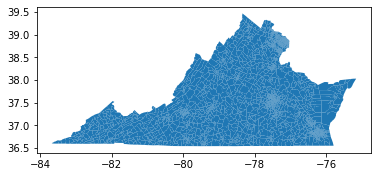

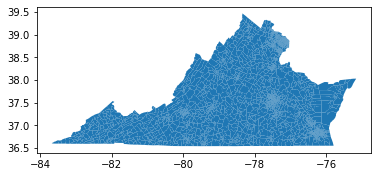

In [17]:
#Assign vest file crs to a variable to use throughout
proj = final.crs
#Create list of files to load in
county_fips = []
for directory in os.listdir('./vest_va/census_shps_by_county_all_unzip/'):
    if not directory[0] == '.':
        county_fips.append(directory[-5:])
#Read in precinct shapefiles for all VA counties
county_vtds = []
for i in county_fips:
    ref = './vest_va/census_shps_by_county_all_unzip/partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
    #print(i, ' added to list')
    county_vtds.append(vtd_shp)
#Create gdf with all VA counties
global shp
shp = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 
print('see below census shapefile plotted followed by VESTs final file plotted')
shp.plot()
final.plot()

In [18]:
#Create unique id in shp using same formatting as for the df and vest file
shp['unique_id'] = shp['COUNTYFP'] + shp['VTDST'].str.slice(start = 3)
print('initial shp unique id # unique: ', shp.unique_id.nunique())
#create unique_id_1 in shp as baseline to change from
shp['unique_id_1'] = shp['unique_id']
#Off the bat, can change the following two ids
d = {'003407':'003499', '003507': '003599'}
shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1']=shp.loc[shp['unique_id'].isin(d.keys()), 'unique_id_1'].map(d)

initial shp unique id # unique:  2461


### Refining shp unique id match to election results

**#Process not shown: printed set differences between unique ids in shp and final files, then compared side by side in excel to find overlap/create dictionary**

In [19]:
#final_uniqe_not_in_shp = list(set(final.unique_id) - set(shp.unique_id_1))
#final[final['unique_id'].isin(final_uniqe_not_in_shp)]
#shp_unique_id_missing = list(set(shp.unique_id_1) - set(final.unique_id))
#plot fries part 1 and 2, should come out the same
#shp[shp['unique_id'].isin(shp_unique_id_missing)]
print('vest file unique_id #unique: ', final.unique_id.nunique(), 'vest file shape', final.shape)
print('df unique_id #unique: ', df_with_absentee_reallocated.unique_id.nunique(), 'df shape', df_with_absentee_reallocated.shape)

vest file unique_id #unique:  2441 vest file shape (2463, 12)
df unique_id #unique:  2440 df shape (2462, 25)


In [20]:
shp_id_list = list(set(shp['unique_id']) - set(df_with_absentee_reallocated['unique_id']))
df_id_list = list(set(df_with_absentee_reallocated['unique_id']) - set(shp['unique_id']))

print('shp shape: ', shp.shape[0])
print('length of shp ids not in the df: ', len(shp_id_list))
print('df shape: ', df_with_absentee_reallocated.shape[0])
print('length of df ids not in the shp: ', len(df_id_list))

shp['COUNTYFP'][shp['unique_id'].isin(shp_id_list)].value_counts()

shp shape:  2462
length of shp ids not in the df:  29
df shape:  2462
length of df ids not in the shp:  8


041    5
153    4
520    2
077    2
191    2
685    2
510    2
550    2
121    2
095    2
760    2
161    1
750    1
059    1
Name: COUNTYFP, dtype: int64

**See below, commented out was used to hand check all by Name/Precinct/NAMELSAD, then check via plot**

In [21]:
#shp[shp['unique_id'].isin(shp_id_list)]
#df_with_absentee_reallocated[(df_with_absentee_reallocated['COUNTYFP'] == '121') & (df_with_absentee_reallocated['Pct'].str.contains('D'))]
#shp[(shp['unique_id'].str.slice(stop = 3) == '550') & (shp['NAME'].str.contains('Green'))] 
#final[(final['COUNTYFP'] == '550') & (final['PRECINCT'].str.contains('Green'))]
#df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_id_list)]
#df_with_absentee_reallocated[(df_with_absentee_reallocated['Pct'].str.contains('Westgate'))]
#df_county_rep = list(df_with_absentee_reallocated['COUNTYFP'][df_with_absentee_reallocated['unique_id'].isin(df_id_list)])
#df_with_absentee_reallocated[df_with_absentee_reallocated['COUNTYFP'].isin(df_county_rep) & df_with_absentee_reallocated['unique_id'].isin(df_id_list)]

In [22]:
# Values from Excel hand matching keys to values
merge_dict = {'153114': '153109-1', # do not look like they matchPiney Branch
 '153061': '153106-1', #Westgate part 1 -- on map looks like it this is the only match ?merge
 '153062': '153106-1', #?merge Westgate part 2 -- westgate is normal Polygon z in final file
 #: 153315 - Williams voting District from shp does not seem to have a match in df
 '191021': '191702-9', #merge Wallace part 1
 '191022': '191702-9', #merge Wallace part 2 -- multipolygon in final file - merge shp
 '760415': '760114-4', #? does not look like it matches based on polygons only one that contains 4 that is not in shp file also??
 #no match in 760 county for : 760215 from shp dataset
 #no match in 750 county for : '750004'
 '685031': '685003-10', #merge Precint three part 1
 '685032': '685003-10', #merge Precinct three part 2
 #: 059700 -- no match - in Final and shp, not in df -- zero votes
 '095041': '095104-2', #merge Berkeley part 1
 '095042': '095104-2', #merge Berkeley part 2
 '161401': '161405-6', # merge with exsiting 161405 "North LINDENWOOD" with this "South LINDENWOOD"
 '550064': '550006-4', # merge Deep creek II -- merge with existing 550006
 '550065': '550049-4', # merge Waterway II -- merge with exisiting 550049
 '041113': '041111-4', # merge with existing 041111
 '077011': '077401-9', #merge Fries part 1 - merge
 '077012': '077401-9', #merge Fries part 2 - merge
 #: 510302 and 
 #: 510112 do not seem to have matches in df from shp
 '520041': '520004-9', #merge Fourth Ward Part 1
 '520042': '520004-9', #merge Fourth Ward Part 2
 '121032': '121203-9', #vtdst = 002032 - B3 part 2 merge with part 1 existing (121203)
 #'121032': '121403-9' #vtdst = 004032 - D3 part 2 - merge with part 1 existing -- this and previous need new ID to distinguish ... or not just cut it ?121032 does not match the final version
    #'550040-3': , #River birch missing in shp
    #'550047-4':  #Green Sea missing in shp
} 

#10 merge (existing in df, merge in shp)
#6 in shp not in df
#2 in df not in
#2 in shp and df just need dict
#2 in shp merge to existing id
#so, 10 remain as is in shp, 10 -->5 in shp due to merge
#can see creeks/rivers missing

In [23]:
#Make unique_id column in shp based on the original unique id, but replace values where possible using the dictionary above
shp['unique_id_2'] = shp['unique_id']
shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_2'] = shp.loc[shp['unique_id'].isin(merge_dict.keys()), 'unique_id_2'].map(merge_dict)

shp = shp.dissolve(by = 'unique_id_2', as_index = False)

#unique id column where congressional district only added from column `unique_id_1` to the end where needed to account for double values from `unique_id`
df_with_absentee_reallocated['unique_id_2'] = df_with_absentee_reallocated['unique_id']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list), 'unique_id_2'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id'].isin(df_double_list), 'unique_id_1']
df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_dict.values()), 'unique_id_2'] = df_with_absentee_reallocated.loc[df_with_absentee_reallocated['unique_id_1'].isin(merge_dict.values()), 'unique_id_1']

#same as on df on VEST's file's unique ids
final['unique_id_2'] = final['unique_id']
final.loc[final['unique_id'].isin(df_double_list), 'unique_id_2'] = final.loc[final['unique_id'].isin(df_double_list), 'unique_id_1']
final.loc[final['unique_id_1'].isin(merge_dict.values()), 'unique_id_2'] = final.loc[final['unique_id_1'].isin(merge_dict.values()), 'unique_id_1']

#match final two between df and vest file:
dict_99to07 = {'003499':'003407', '003599':'003507'}
final.loc[final['unique_id_2'].isin(dict_99to07.keys()), 'unique_id_2'] = final.loc[final['unique_id_2'].isin(dict_99to07.keys()), 'unique_id_2'].map(dict_99to07)

print('after hand matching, # ids in shp not in df: ', len(set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2'])), '#unique in shp col: ', shp.unique_id_2.nunique())
print('after hand matching, # ids in df not in shp: ', len(set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2)), '#unique in df col: ', df_with_absentee_reallocated.unique_id_2.nunique())

#make dictionary using df and apply to shp to better match id's
df_dict_unique_id = pd.Series(df_with_absentee_reallocated['unique_id_1'].values, index = df_with_absentee_reallocated['unique_id']).to_dict()
shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_2'] = shp.loc[shp['unique_id'].isin(df_double_list), 'unique_id_2'].map(df_dict_unique_id)

print('after df dict matching, # ids in shp not in df: ', len(set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2'])), '#unique in shp col: ', shp.unique_id_2.nunique())
print('after df dict matching, # ids in df not in shp: ', len(set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2)), '#unique in df col: ', df_with_absentee_reallocated.unique_id_2.nunique())


after hand matching, # ids in shp not in df:  39 #unique in shp col:  2455
after hand matching, # ids in df not in shp:  46 #unique in df col:  2462
after df dict matching, # ids in shp not in df:  17 #unique in shp col:  2455
after df dict matching, # ids in df not in shp:  24 #unique in df col:  2462


In [38]:
#No match
#set(shp.unique_id_2) - set(df_with_absentee_reallocated['unique_id_2'])
#set(df_with_absentee_reallocated['unique_id_2']) - set(shp.unique_id_2)

# Validation

## Join election results and shapefile

In [67]:
gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id_2', how = 'inner'), crs = proj).shape

(2438, 44)

precinct shp joined to election result shape:  (2479, 44)
precinct shp shape:  (2455, 19)
precinct election result df shape:  (2462,)


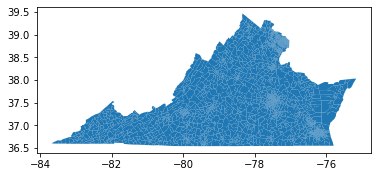

In [52]:
join = gpd.GeoDataFrame(pd.merge(df_with_absentee_reallocated, shp, on = 'unique_id_2', how = 'outer'), crs = proj)
join.plot()
print('precinct shp joined to election result shape: ', join.shape)
print('precinct shp shape: ', shp.shape)
print('precinct election result df shape: ', df_with_absentee_reallocated.unique_id_2.shape)

## Shapfile validation

In [50]:
shp_final_merge = pd.merge(join, final, on = 'unique_id_2', how = 'outer', suffixes = ['_x', '_y'],indicator=True)

both = shp_final_merge[shp_final_merge["_merge"]=="both"]
source_geoms = gpd.GeoDataFrame(both,geometry="geometry_x",crs=final.crs)
vest_geoms = gpd.GeoDataFrame(both,geometry="geometry_y",crs=final.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     1772
False     691
dtype: int64


1) For 301 - South difference in area is 2.4720747911344634
2) For 401 - Central difference in area is 2.4720747911344634
3) For 201 - Beaverdam difference in area is 1.2087147824530082
4) For 202 - Blunts difference in area is 1.2087147824487465
5) For 109 - Piney Branch difference in area is 2.80610678450665
6) For 202 - Jamestown B difference in area is 1.3935597695921642
7) For 15 - B M Williams difference in area is 1.1458024748583129
8) For 104 - Titustown difference in area is 2.062682888050457
9) For 9 - Bells Mill difference in area is 2.8494240900246752
10) For 14 - Grassfield difference in area is 2.5386896592481922
11) For 36 - Great Bridge Baptist Church difference in area is 1.7854579663175758
12) For 49 - Waterway difference in area is 3.856421204127912
13) For 51 - Coopers Way difference in area is 2.158238975650281
14) For 111 - Iron Bridge difference in area is 5.329836884523934
15) For 304 - Winfrees Store difference in area is 7.916646768539404
16) For 302 - John F 

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For 502 - Buffalo Hts difference in area is 2.293644305239482
24) For 601 - Prospect difference in area is 1.1636920314767547
25) For 405 - Lindenwood difference in area is 1.2373462848561305
26) For 213 - Southside difference in area is 1.1100167365461477
27) For 309 - Skinquarter difference in area is 11.693771424346881
28) For 402 - Genito difference in area is 2.248559309256872
29) For 202 - Sandy Hook difference in area is 1.0661417587320714
30) For 401 - Shallow Well difference in area is 2.6975778668525776
31) For 402 - Centerville difference in area is 2.6986463563414844
32) For 702 - South Anna difference in area is 1.4164754942498499
33) For 103 - Travelers Rest difference in area is 1.1611291621829944
34) For 402 - Parkside difference in area is 1.528646875367698
35) For 304 - Mount Olivet difference in area is 3.9051818156290947
36) For 505 - Dyers Store difference in area is 1.1759502663231916
37) For 203 - Precinct B-3 difference in area is 2.0474429480939236
38) For 

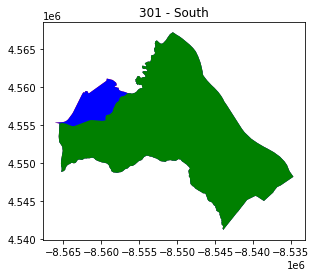

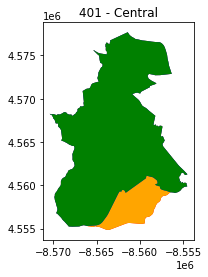

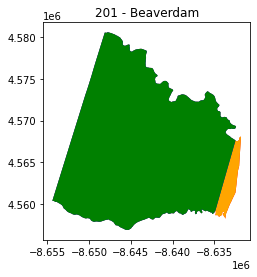

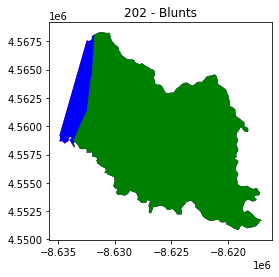

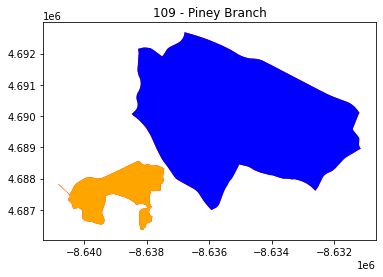

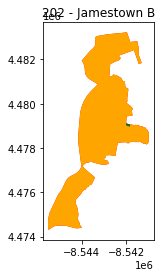

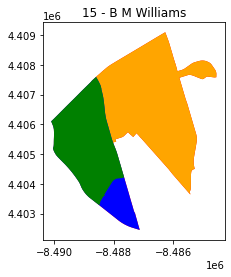

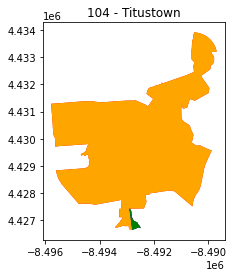

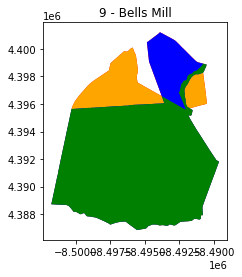

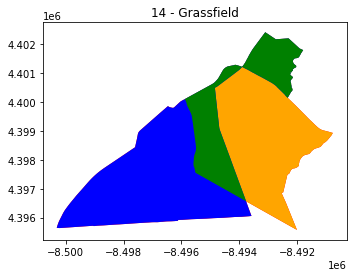

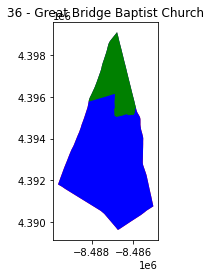

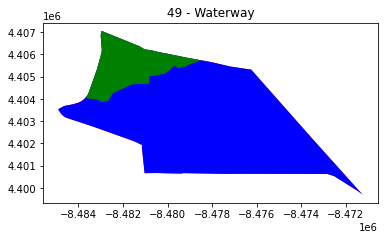

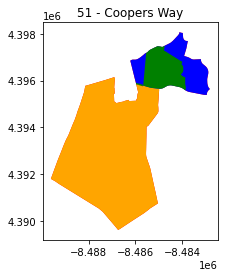

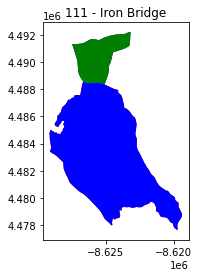

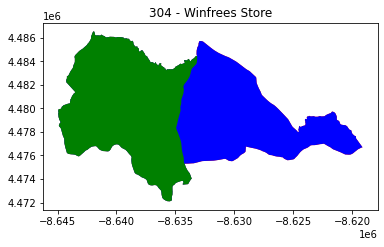

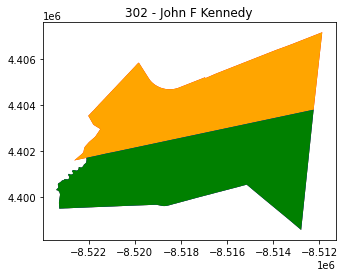

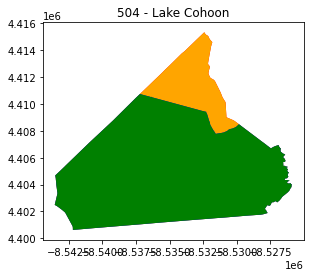

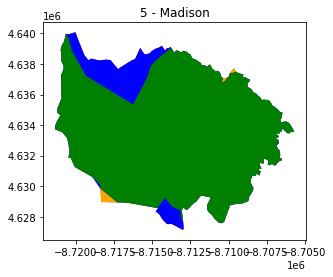

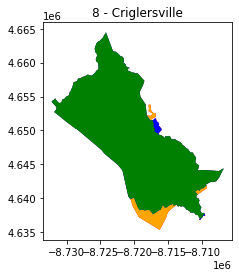

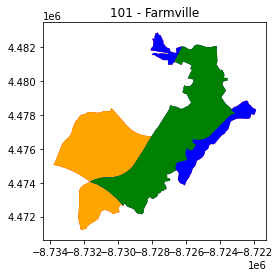

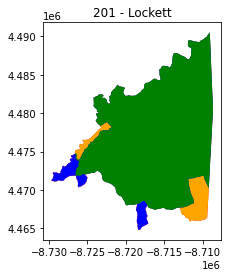

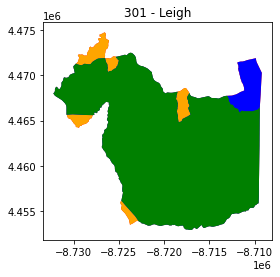

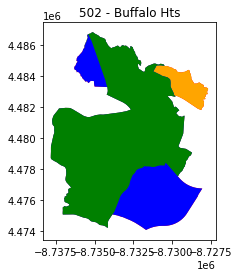

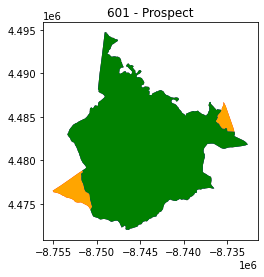

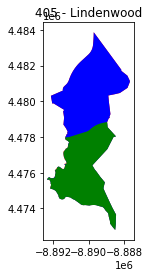

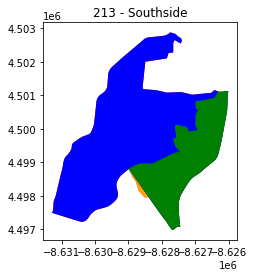

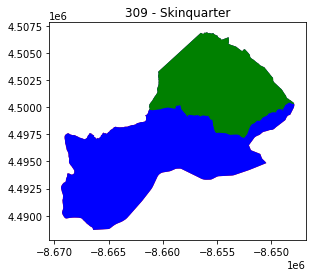

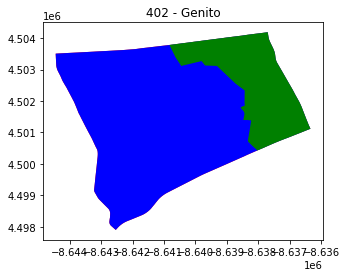

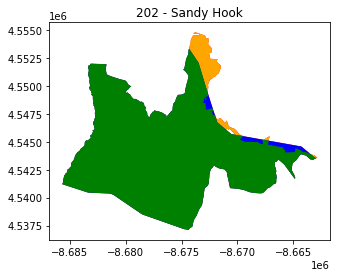

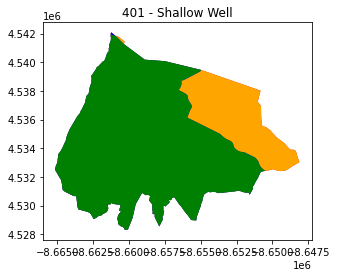

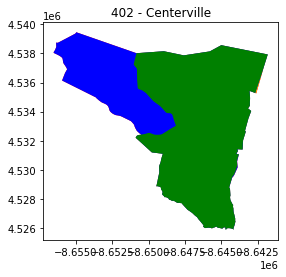

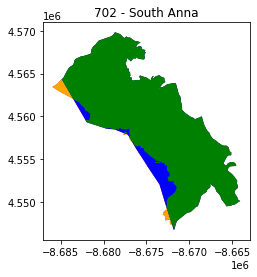

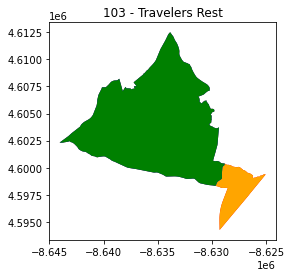

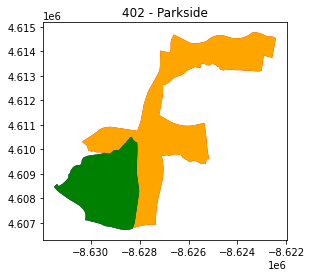

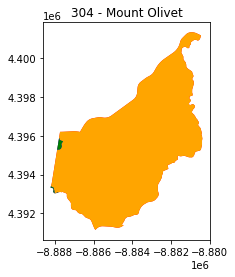

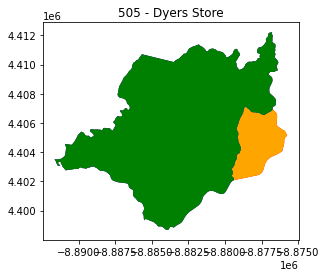

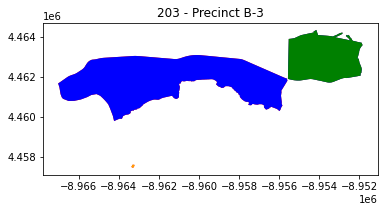

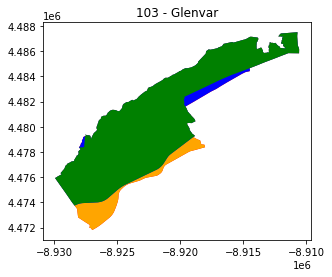

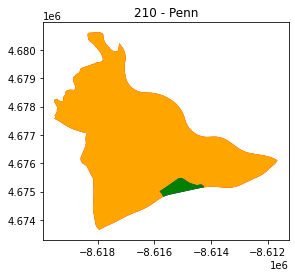

In [53]:
count = 0
area_list = []
big_diff = pd.DataFrame(columns=["area"])
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > 1):
        count += 1
        name = source_geoms.at[i,"Pct"]
        big_diff.loc[name]=area
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [54]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2463, 1)
1791 precincts w/ a difference of 0 km^2
531 precincts w/ a difference between 0 and .1 km^2
60 precincts w/ a difference between .1 and .5 km^2
18 precincts w/ a difference between .5 and 1 km^2
16 precincts w/ a difference between 1 and 2 km^2
20 precincts w/ a difference between 2 and 5 km^2
3 precincts w/ a difference greater than 5 km^2


## Merge and check precinct level election results

In [55]:
final_df_merge = pd.merge(join, final, on = 'unique_id_2', how = 'outer')

In [59]:
col_list = ['G18HORDEM', 'G18HORREP', 'G18HORLIB', 'G18HORWRI']

In [60]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["unique_id_2"]), "(V)","{:.>5}".format(int(df.iloc[j][right_Data]))," (S){:.>5}".format(int(df.iloc[j][left_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["unique_id_2"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["unique_id_2"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [1]:
validater_row(final_df_merge, col_list)

NameError: name 'validater_row' is not defined